# Train/Test Split and Bias and Variance

---

<a id="learning-objectives"></a>
### Learning Objectives
*By the end of this notebook you will be able to:*
- Define error due to bias and error due to variance.
- Identify the bias-variance trade-off.
- Describe what overfitting and underfitting means in the context of model building.
- Explain problems associated with over- and underfitting.
- Grasp why train/test split is necessary.
- Explore k-folds, LOOCV, and three split methods.

<a id="bias-and-variance-trade-off"></a>
# <font color='blue'> Bias and variance tradeoff
---
The **bias-variance tradeoff** is widely used in machine learning as a conceptual way of comparing and contrasting different models. 

**Bias: How close are predictions to the actual values?** 

* Bias is error stemming from incorrect model assumptions
* If the model cannot represent the data's structure, our predictions could be consistent, but will not be accurate.
* **Example**: Assuming data is linear when it has a more complicated structure.

**Variance:  How variable are our predictions?** 
* Variance is error stemming from being overly sensitive to changes in the training data.
* A model with high variance will make very different predictions given slightly different training sets.
* **Example**: Using the training set exactly (e.g. 1-NN) for a model results in a completely different model -- even if the training set differs only slightly.


As model complexity **increases**:
- Bias **decreases**. (The model can more accurately model complex structure in data.)
- Variance **increases**. (The model identifies more complex structures, making it more sensitive to small changes in the training data.)

![](./assets/biasVsVarianceImage.png) 


<a id="exploring-the-bias-variance-tradeoff"></a>
## <font color='red'> Now you try: High bias, low variance
    
Let's try building models with high variance/low bias, and low variance/high bias.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Allow plots to appear in the notebook.
%matplotlib inline

Let's read in the mammals dataset.

This is a [data set](http://people.sc.fsu.edu/~jburkardt/datasets/regression/x01.txt) of the average weight of the body (in kg) and the brain (in g) for 62 mammal species. 

We'll use this dataset to investigate bias vs. variance. Let's read it into Pandas and take a quick look:

In [4]:
path = './data/mammals.txt'
cols = ['brain','body']
mammals = pd.read_table(path, sep='\t', names=cols, header=0)
mammals.head()

brain   body
0    3.385   44.5
1    0.480   15.5
2    1.350    8.1
3  465.000  423.0
4   36.330  119.5

In [5]:
mammals.describe()

brain         body
count    62.000000    62.000000
mean    198.789984   283.134194
std     899.158011   930.278942
min       0.005000     0.140000
25%       0.600000     4.250000
50%       3.342500    17.250000
75%      48.202500   166.000000
max    6654.000000  5712.000000

We're going to focus on a smaller subset in which the body weight is less than 200 kg.

In [6]:
# Only keep rows in which the body weight is less than 200 kg.
mammals = mammals[mammals.body < 200]
mammals.shape

(51, 2)

We're now going to pretend that there are only 51 mammal species in existence. In other words, we are pretending that this is the entire data set of brain and body weights for **every known mammal species**.

Let's create a scatterplot (using [Seaborn](http://stanford.edu/~mwaskom/software/seaborn/)) to visualize the relationship between brain and body weight:

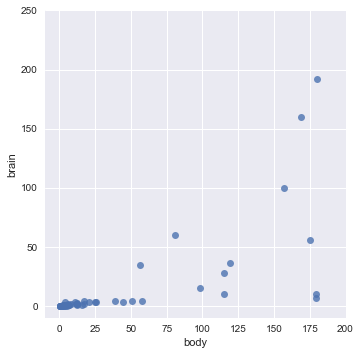

In [5]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None, fit_reg=False);
sns.plt.xlim(-10, 200);
sns.plt.ylim(-10, 250);

There appears to be a relationship between brain and body weight for mammals.

Now let's pretend that a **new mammal species** is discovered. We measure the body weight of every member of this species we can find and calculate an **average body weight of 100 kgs**. We want to **predict the average brain weight** of this species (rather than measuring it directly). How might we do this?

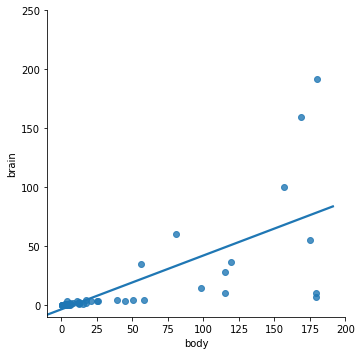

In [10]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None);
plt.xlim(-10, 200);
plt.ylim(-10, 250);

We drew a straight line that appears to best capture the relationship between brain and body weight. So, we might predict that our new species has a brain weight of about 45 g, as that's the approximate y value when x=100.

Earlier, we assumed that this dataset contained every known mammal species. That's very convenient, but **in the real world, all you ever have is a sample of data**. This may sound like a contentious statement, but the point of machine learning is to generalize from a sample to the population. If you already have data for the entire population, then you have no need for machine learning -- you can apply statistics directly and get optimal answers!

Here, a more realistic situation would be to only have brain and body weights for (let's say) half of the 51 known mammals.

When that new mammal species (with a body weight of 100 kg) is discovered, we still want to make an accurate prediction for its brain weight, but this task might be more difficult, as we don't have all of the data we would ideally like to have.

Let's simulate this situation by assigning each of the 51 observations to **either universe 1 or universe 2**:

In [11]:
# Set a random seed for reproducibility.
np.random.seed(12345)

# Randomly assign every observation to either universe 1 or universe 2.
mammals['universe'] = np.random.randint(1, 3, len(mammals))
mammals.head()

brain   body  universe
0   3.385   44.5         1
1   0.480   15.5         2
2   1.350    8.1         2
4  36.330  119.5         2
5  27.660  115.0         1

**Important:** We only live in one of the two universes. Both universes have 51 known mammal species, but each universe knows the brain and body weight for different species.

We can now tell Seaborn to create two plots in which the left plot only uses the data from **universe 1** and the right plot only uses the data from **universe 2**:

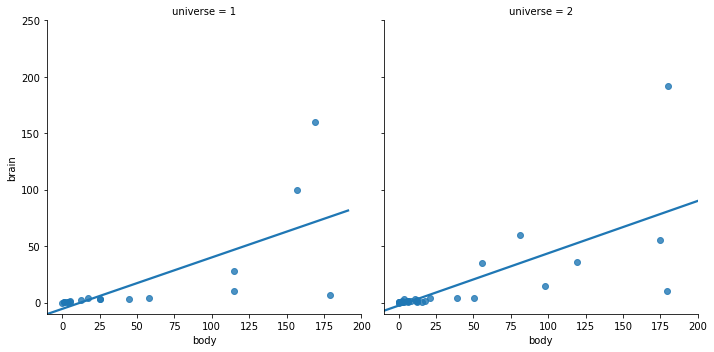

In [13]:
# col='universe' subsets the data by universe and creates two separate plots.
sns.lmplot(x='body', y='brain', data=mammals, ci=None, col='universe');
plt.xlim(-10, 200);
plt.ylim(-10, 250);

The line looks pretty similar between the two plots, despite the fact that they used separate samples of data. In both cases, we would predict a brain weight of about 45 g.

It's easier to see the degree of similarity by placing them on the same plot:

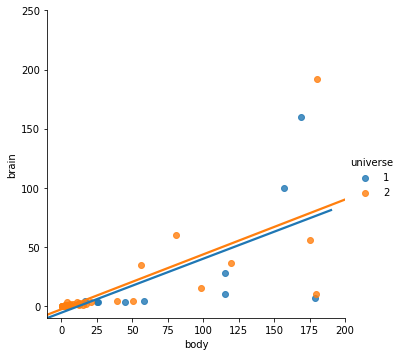

In [15]:
# hue='universe' subsets the data by universe and creates a single plot.
sns.lmplot(x='body', y='brain', data=mammals, ci=None, hue='universe');
plt.xlim(-10, 200);
plt.ylim(-10, 250);

So, what was the point of this exercise? This was a visual demonstration of a high-bias, low-variance model.

- It's **high bias** because it doesn't fit the data particularly well.
- It's **low variance** because it doesn't change much depending on which observations happen to be available in that universe.

<a id="lets-try-something-completely-different"></a>
## <font color='red'> Now you try: Low bias, high variance

What would a **low-bias, high-variance** model look like? Let's try polynomial regression with an eighth-order polynomial.

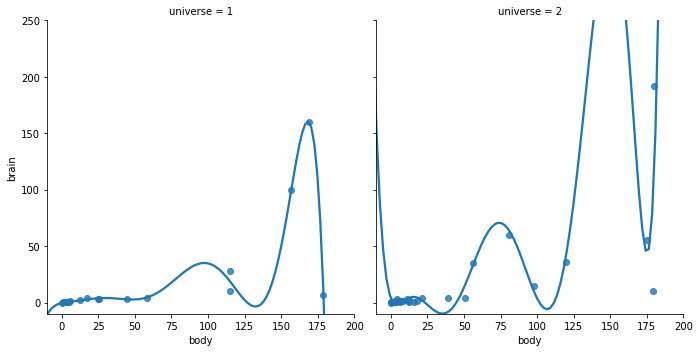

In [17]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None, col='universe', order=8);
plt.xlim(-10, 200);
plt.ylim(-10, 250);

- It's **low bias** because the models match the data effectively.
- It's **high variance** because the models are widely different, depending on which observations happen to be available in that universe. (For a body weight of 100 kg, the brain weight prediction would be 40 kg in one universe and 0 kg in the other!)

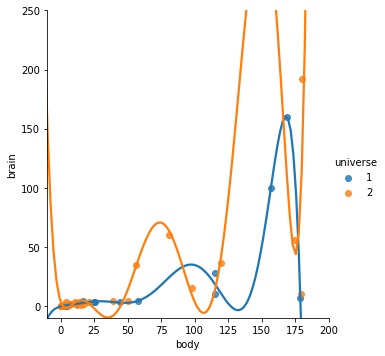

In [18]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None, hue='universe', order=8);
plt.xlim(-10, 200);
plt.ylim(-10, 250);

<a id="balancing-bias-and-variance"></a>
## <font color='red'> Now you try: Balancing bias and variance
    
Can we find a middle ground?

Perhaps we can create a model that has **less bias than the linear model** and **less variance than the eighth order polynomial**?

Let's try a second order polynomial instead:

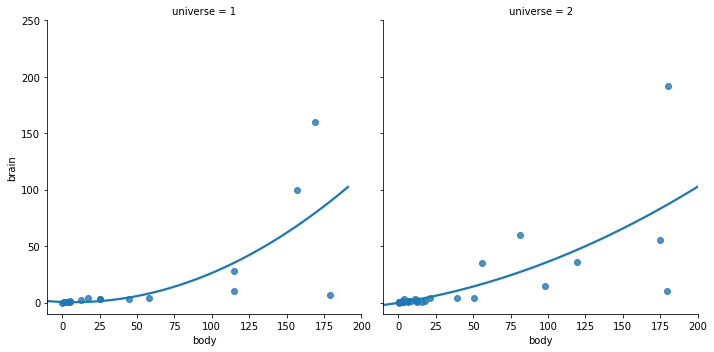

In [20]:
sns.lmplot(x='body', y='brain', data=mammals, ci=None, col='universe', order=2);
plt.xlim(-10, 200);
plt.ylim(-10, 250);

This seems better. In both the left and right plots, **it fits the data well, but not too well**.

This is the essence of the **bias-variance trade-off**: You are seeking a model that appropriately balances bias and variance and thus will generalize to new data (known as "out-of-sample" data).

We want a model that best balances bias and variance. It
should match our training data well (moderate bias) yet be low variance for out-of-sample data (moderate variance).

- Training error as a function of
complexity.
- Question: Why do we even
care about variance if we
know we can generate a
more accurate model with
higher complexity?

### Can we obtain a zero-bias, zero-variance model?

No! If there is any noise in the data-generating process, then a zero-variance model would not be learning from the data. Additionally, a model only has zero bias if the true relationship between the target and the features is hard-coded into it. If that were the case, you wouldn't be doing machine learning -- it would be similar to trying to predict today's temperature by using today's temperature!

---
<a id="train-test-split"></a>
# <font color='blue'> Training and testing split

For the rest of the lab, we will look at three evaluation procedures for predicting model out-of-sample accuracy. 


1. **Train-test-split** is useful if cross-validation is not practical (e.g. it takes too long to train). It is also useful for computing a quick confusion matrix. You could also use this as a final step after the model is finalized (often called evaluating the model against a **validation set**).


2. **Cross-validation** is the gold standard for estimating accuracy and comparing accuracy across models.



3. **Three-way split** combines cross-validation and the train-test-split. It takes an initial split to be used as a final validation set, then uses cross-validation on the rest.


We'll be running a linear regression model to do this.

<a id="train-test-split-1"></a>
## <font color='red'> Now you try: Training and testing split

Let's start by reading in the Boston housing dataset.

Drop rows containing missing values.

In [65]:
housing = pd.read_csv('./data/boston_housing.csv')
housing.dropna(inplace=True)
housing.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222     18.7   
5  0.02985   0.0   2.18   0.0  0.458  6.430  58.7  6.0622    3  222     18.7   

   LSTAT  MEDV  
0   4.98  24.0  
1   9.14  21.6  
2   4.03  34.7  
3   2.94  33.4  
5   5.21  28.7

Now, scale each **feature** to fall between 0 and 1. This means:


* It will be possible to compare the relative importances of the different features by interpreting their coefficients.


* It won't be possible to interpret the coefficients in a real-world context, i.e. we won't be able to make statements like "for every extra bedroom added to a house, its value increases by $1000".

In [66]:
from sklearn.preprocessing import MinMaxScaler

cols_to_scale = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','LSTAT']

scaler = MinMaxScaler()

housing_scaled = pd.DataFrame(scaler.fit_transform(housing[cols_to_scale]), columns=cols_to_scale)


Next, check which variables are normally distributed. You can do this using a `pairplot` or `hist`. 



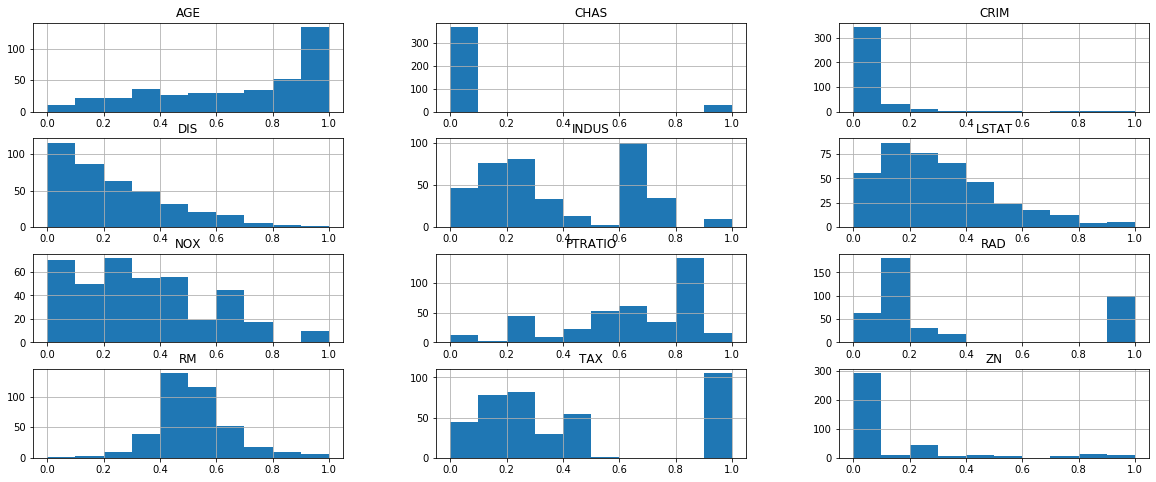

In [67]:
housing_scaled.hist(figsize=(20,8));

Remove variables that aren't normally distributed.

In [68]:
housing_scaled.drop(columns=['CHAS','ZN','CRIM'],inplace=True)

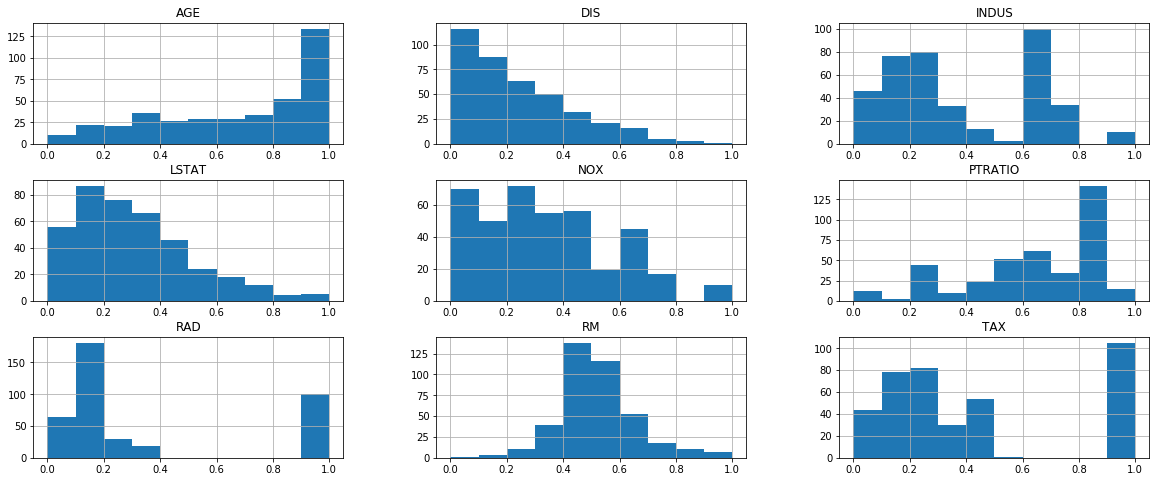

In [69]:
housing_scaled.hist(figsize=(20,8));

Split the data into a training and testing set, where the testing set is 30% of the data.

In [70]:
from sklearn.model_selection import train_test_split

X = housing_scaled[['INDUS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','LSTAT']]
y = housing['MEDV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Train and test a linear regression model on this data; compare its performance to a baseline model.

In [73]:
from sklearn.linear_model import LinearRegression # import
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import mean_squared_error

linreg = LinearRegression() # initialise

linreg.fit(X_train, y_train) # fit

mse = mean_squared_error(y_train, linreg.predict(X_train))
rmse = np.sqrt(mse)

print('Mean squared TRAINING error: %f'% mse)
print('Root mean squared TRAINING error: %f'% rmse)

mse = mean_squared_error(y_test, linreg.predict(X_test))
rmse = np.sqrt(mse)

print('Mean squared TESTING error: %f'% mse)
print('Root mean squared TESTING error: %f'% rmse)



Mean squared TRAINING error: 21.159204
Root mean squared TRAINING error: 4.599913
Mean squared TESTING error: 23.795245
Root mean squared TESTING error: 4.878037


In [75]:
null_model = np.mean(y_train)*np.ones(len(y_test))

mse = mean_squared_error(y_test, null_model)
rmse = np.sqrt(mse)

print('Mean squared baseline model error: %f'% mse)
print('Root mean squared baseline model error: %f'% rmse)

Mean squared baseline model error: 90.949778
Root mean squared baseline model error: 9.536759


<a id="k-folds-cross-validation"></a>
## K-fold cross validation
---

Train/test split provides us with helpful tool, but it's a shame that we are tossing out a large chunk of our data for testing purposes.

**How can we use the maximum amount of our data points while still ensuring model integrity?**

1. Split our data into a number of different pieces (folds).
2. Train using `k-1` folds for training and a different fold for testing.
3. Average our model against EACH of those iterations.
4. Choose our model and TEST it against the final fold.
5. Average all test accuracies to get the estimated out-of-sample accuracy.

Although this may sound complicated, we are just training the model on k separate train-test-splits, then taking the average of the resulting test accuracies!

<a id="leave-one-out-cross-validation"></a>
### Leave-One-Out Cross-Validation

A special case of k-fold cross-validation is leave-one-out cross-validation. Rather than taking 5–10 folds, we take a fold of size `n-1` and leave one observation to test. 

Typically, 5–10 fold cross-validaiton is recommended.

Let's see how k-fold cross validation works!

In [102]:
from sklearn.model_selection import cross_val_score
    
linreg = LinearRegression()
scores = cross_val_score(linreg, X, y, cv=5,scoring='neg_mean_squared_error')

scores



array([-11.7413262 , -20.33563568, -32.87336777, -69.61703117,
       -27.85956701])

## <font color='red'> K-fold cross validation
    
1. Can you convert the scores above into positive values of root mean squared error? 


2. What's the mean error across five folds?


Now, let's try k-fold cross validation on our US Presidential data.


1. Read in the dataset. 
2. Drop rows containing missing values.
3. Normalise each feature column so the values all fall between 0 and 1
4. Remove features that aren't normally distributed
5. Using linear regression models and 10-fold cross validation, compute the root mean squared errors of all 10 models. T
6. Find the mean error across all 10 models.

<a id="three-way-data-split"></a>
## Three-Way Data Split
---

The most common workflow is actually a combination of train/test split and cross-validation. 

We take a train/test split on our data right away.

We then take our training data and tune our models using cross-validation. 

When we think we are done, we do one last test on the testing data to make sure we haven't accidently overfit to our training data.

**If you tune hyperparameters via cross-validation, you should never use cross-validation on the same dataset to estimate OOS accuracy!** 

Using cross-validation in this way, the entire dataset is used to tune hyperparameters. So, this invalidates our condition above -- where we assumed the test set is a pretend "out-of-sample" dataset that was not used to train our model! So, we would expect the accuracy on this test set to be artificially inflated as compared to actual "out-of-sample" data.

Even with good evaluation procedures, it is incredible easy to overfit our models by including features that will not be available during production or leak information about our testing data in other ways.